In [1]:
import islpy as isl
from latex_op import display_latex
from islplot_support import plot_uset, plot_umap

# Schedules

$\{ (i,j,k) \to$ ⏰ $(i+j, k, i) \}$


## Definition
The iteration domain of statements gives information about the *instances* to be executed but does not specify in which order.
In fact, we can specify any piece-wise quasi-linear order by assigning logical execution dates to each statement instance.
Concisely, this *schedule* can be expressed as a Presburger map between statement instances and logical dates.

## Identity Schedule
By default, statement instances are executed following the loop iteration order.
This can be expressed using an *identity* schedule relation.

For example, the simple initialization loop
```c
for (i = 0; i < N; ++i)
S:  A[i] = 0.0;
```
with iteration domain

$$
\mathcal{D}_\mathtt{S} = [N] \rightarrow \{ \mathtt{S}(i) : 0 \leq i < N \}
$$

can have an identity schedule

$$
\mathcal{T}_\mathtt{S} = [N] \rightarrow \{ \mathtt{S}(i) \rightarrow (t\_0) : t\_0 = i \}
$$

In *isl* notation, this is expressed as

In [2]:
D_S = isl.Set("[N] -> {S[i]: 0 <= i < N}")
T_S = isl.Map("[N] -> {S[i] -> [t0]: t0 = i}")
display_latex(T_S)

<IPython.core.display.Math object>

## Multidimensional Schedules
If a statement instance is identified by a vector of more than one element, i.e. the statement is enclosed in multiple nested loops,
it is usually mapped to a *multidimensional* logical dates.
In this case, the statement instances are executed following the *lexicographical order* of their logical dates.
For example, the date $(0,42)$ precedes the date $(100,0)$.  We denote this as $(0,42) \prec (100,0)$.
The lexicographical order is usually extended to compare vectors of different size.
A shorter vector that is a prefix of a longer vector precedes it, for example $(0,42) \prec (0,42,0)$.

For example, zero-initialization of a two-dimensional array
```c
for (i = 0; i < N; ++i)
  for (j = 0; j < N; ++j)
S:  A[i][j] = 0.0;
```
has the iteration domain

$$
\mathcal{D}_\mathtt{S} = [N] \rightarrow \{ \mathtt{S}(i): 0 \leq i,j < N \}
$$

will have the identity schedule

$$
\mathcal{T}_\mathtt{S} = [N] \rightarrow \{ \mathtt{S}(i,j) \rightarrow (t_0, t_1) : t_0 = i \wedge t\_1 = j \}
$$

In *isl* notation, this is expressed as

In [3]:
D_S = isl.Set("[N] -> {S[i,j]: 0 <= i,j < N}")
T_S = isl.Map("[N] -> {S[i,j] -> [t0,t1]: t0 = i and t1 = j}")
display_latex(T_S)

<IPython.core.display.Math object>

Even if in theory the schedule can be expressed using a single dimension
$$
\mathcal{T}_\mathtt{S} = [N] \rightarrow \{ \mathtt{S}(i,j) \rightarrow (t_0) : t_0 = Ni + j \} 
$$
such expression cannot be represented as a Presburger map due to multiplication of the variables.
However, such schedules can be constructed when the actual constant is used instead of a constant parameter.

### Question
Propose an identity schedule for the initialization loop of a three-dimensional array
```c
for (i = 0; i < N; ++i)
  for (j = 0; j < N; ++j)
    for (k = 0; k < N; ++k)
T:    A[i][j] = 0.0;
```

In [4]:
#!Solution
D_T = isl.Set("[N] -> {S[i,j,k]: 0 <= i,j,k < N}")
T_T = isl.Map("[N] -> {S[i,j,k] -> [t0,t1,t2]: t0 = i and t1 = j and t2 = k}")
display_latex(T_T)

<IPython.core.display.Math object>

### Question
Try defining a one-dimensional schedule with multiplication for the same domain (error expected).

In [5]:
#!Solution
T_T_err = isl.Map("[N] -> {S[i,j,k] -> [t0]: t0 = N*N*i + N*j + k}")

Error: call to isl_map_read_from_str failed: syntax error in isl/isl_stream.c:140

## Representing Lexical Order
Consider the loop nest with two statements
```c
for (i = 0; i < 10; ++i) {
P:  A[i] = 0.0;
Q:  B[i] = 1.0;
}
```
Using plain identity schedule for both statement would result in them having *identical* dates.
Yet it is clear from the code that instances of `Q` are executed *after* the respective instances of `P`.
This *lexical order* of the statements can be encoded in the schedule relations using an *auxiliary* dimension.
It is assigned a constant so as to force instances of `P` to be executed before instances of `Q`,
i.e. the constant for `P` is smaller than the one for `Q`.
Because the order exists *inside* the loop, the auxiliary dimension is placed after the loop dimension.

\begin{align*}
\mathcal{T} &= \{ P(i) \rightarrow (t_0, t_1) : t_0 = i \wedge t_1 = 0 \} \cup \\
  &\quad\quad\{ Q(i) \rightarrow (t_0, t_1) : t_0 = i \wedge t_1 = 1 \} 
\end{align*}

This map will assign dates $(i,0)$ to the instances of `P` and dates $(i,1)$ to the instances of `Q`.
It is clear that $\forall i, (i,0) \prec (i,1)$.
In *isl*, schedules for different statements can be combined into a union map.

In [6]:
D = isl.UnionSet("{P[i]: 0 <= i < 10; Q[i]: 0 <= i < 10}")
S = isl.UnionMap("{P[i] -> [t0,t1]: t0 = i and t1 = 0; Q[i] -> [t0,t1]: t0 = i and t1 = 1}")
display_latex(S)

<IPython.core.display.Math object>

### 
Consider the SCoP with two loops
```c
for (i = 0; i < 10; ++i) {
U:  A[i] = 0.0;
}
for (i = 0; i < 10; ++i) {
V:  B[i] = 1.0;
}
```
In this case, *all* instances of `U` are executed before *any* instance of `V`.
Therefore, the auxiliary dimension is introduced *before* the loop dimension.

\begin{align*}
\mathcal{T} &= \{ U(i) \rightarrow (t_0, t_1) : t_0 = 0 \wedge t_1 = i \} \cup \\
  &\quad\quad\{ V(i) \rightarrow (t_0, t_1) : t_0 = 1 \wedge t_1 = i \} 
\end{align*}

Or, in *isl* notation

In [7]:
D2 = isl.UnionSet("{U[i]: 0 <= i < 10; V[i]: 0 <= i < 10}")
S2 = isl.UnionMap("{U[i] -> [t0,t1]: t0 = 0 and t1 = i; V[i] -> [t0,t1]: t0 = 1 and t1 = i}")
display_latex(S2)

<IPython.core.display.Math object>

Plotting the *scheduled domain* can help to see the difference.

In [8]:
usets = [D.apply(S),D2.apply(S2)]

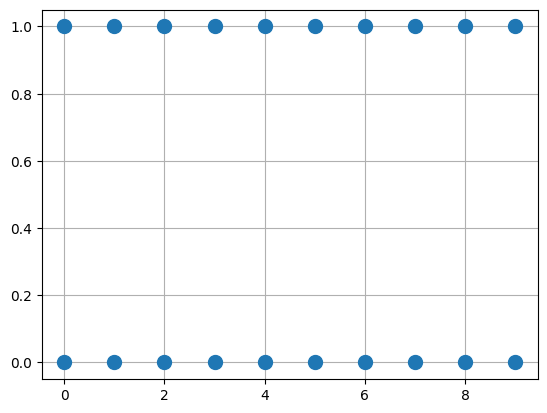

In [9]:
plot_uset(usets[0])
# plot_usets(get_set_list(usets[1]))

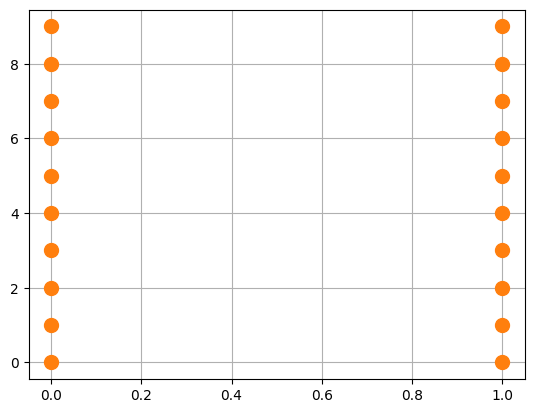

In [10]:
plot_uset(usets[1])

Note that the logical dates live in the *same* space for all statements, therefore one cannot tell them apart visually.

### Question
Generally, an auxiliary dimension is included *after* the last loop the statements share.
If they do not share any loop, it comes foremost.
Define the identity schedule with auxiliary dimensions for the SCoP.
```c
for (i = 0; i < 10; ++i) {
  for (j = 0; j < 5; ++j)
S1: A[i][j] = 0.;
  for (j = 0; j < 5; ++j)
S2: B[i][j] = 0.;
}
```

In [11]:
#!Solution
D = isl.UnionSet("{S1[i,j]: 0 <= i < 10 and 0 <= j < 5; S2[i,j]: 0 <= i < 10 and 0 <= j < 5}")
S = isl.UnionMap("{S1[i,j] -> [t0,t1,t2]: t0 = i and t1 = 0 and t2 = j; S2[i,j] -> [t0,t1,t2]: t0 = i and t1 = 1 and t2 = j}")
display_latex(S)

<IPython.core.display.Math object>